# Pyspark envrioment Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/IDS 561/Project

/content/drive/MyDrive/IDS 561/Project


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -v https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

--2022-04-23 23:00:37--  https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz’

spark-3.1.2-bin-had 100%[===================>] 218.23M  45.3MB/s    in 4.8s    

2022-04-23 23:00:42 (45.8 MB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz’ saved [228834641/228834641]



In [ ]:
!ls

 colab_pdf.py			     __pycache__
 en.openfoodfacts.org.products.csv   ROC.png
'IDS 561_Project.ipynb'		     spark-3.1.2-bin-hadoop3.2.tgz


In [ ]:
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz

spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/index.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.1.2-

In [ ]:
!ls

 colab_pdf.py			     ROC.png
 en.openfoodfacts.org.products.csv   spark-3.1.2-bin-hadoop3.2
'IDS 561_Project.ipynb'		     spark-3.1.2-bin-hadoop3.2.tgz
 __pycache__


In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/IDS 561/Project/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Importing Open Food Facts Dataset

## our dataset is a crowded sourced dataset of food from around the world.

In [ ]:
food_data = spark.read.options(delimiter="\t",header=True).csv("en.openfoodfacts.org.products.csv")

our data is large with over 2 million rows. We are using the pyspark framework to work with the large dataset within google colab.

In [ ]:
food_data.count()

2180138

## Initial Dataset

Here's a quick look at the first 10 rows of the dataset

In [ ]:
food_data.show(n = 10)

+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------------+--------------------+---------------------------+-------------------------+------------------------------+---------------------------------------+-------------------------------------+----------------------------------------

## Schema

Taking a look at the dataset's schema we see there are multiple types of columns including nutrition facts and other identifying columns that aren't relevant to our analysis

In [ ]:
food_data.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- origins_en: string (nullable = 

# Exploratory Analysis

The first thing we wanted to look at was which countries are the most represented in this dataset. So we created a new spark dataframe where we grouped food by "countrie_tags", which is the country of each foods' origin as well as the count for each country.

In [ ]:
from pyspark.sql.functions import col
countries = food_data.groupBy("countries_tags").count().persist()

Next we filtered the countries dataframe by the count column where we only looked at countries with at least 5,000 foods in the dataset and sorted by descending to look at the countries with the most foods in the dataset. France is the most represented country with over 800,000 french foods in the dataset

In [ ]:
countries = countries.filter(col("count") > 5000).orderBy("count",ascending = False)
countries.show()

+--------------------+------+
|      countries_tags| count|
+--------------------+------+
|           en:france|800451|
|    en:united-states|415038|
|            en:spain|235975|
|            en:italy|136852|
|          en:germany| 92685|
|   en:united-kingdom| 58617|
|          en:belgium| 56975|
|      en:switzerland| 56836|
|           en:canada| 46608|
|        en:australia| 17591|
|          en:ireland| 14373|
|en:france,en:germany| 12578|
|  en:france,en:spain| 10848|
|           en:russia|  9118|
|en:belgium,en:france|  8992|
|      en:netherlands|  8717|
|en:france,en:swit...|  8633|
|en:germany,en:ire...|  7938|
|           en:mexico|  6409|
|                null|  6374|
+--------------------+------+
only showing top 20 rows



## Country Representation

In order to visualize the countries dataframe, I converted it into a pandas dataframe to create a bar chart. Once again, France is the country with the highest foods originating from it.

### Bar Chart

Bar chart of country distribution.

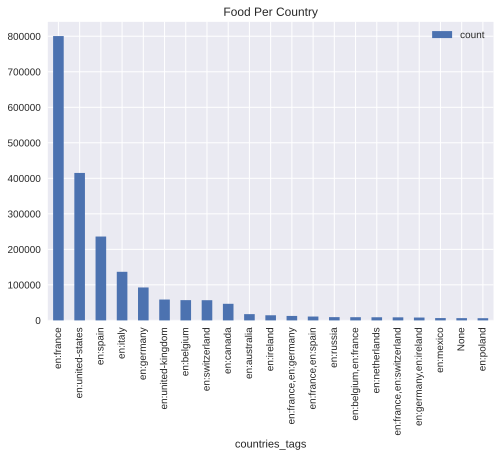

In [ ]:
countries_df = countries.toPandas()
countries_df.plot.bar(x = "countries_tags", y = "count", title = "Food Per Country");

### Pie Chart

Pie chart of country distribution.

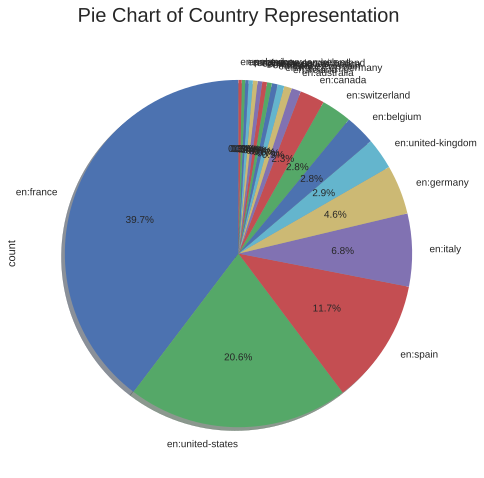

In [ ]:
import matplotlib.pyplot as plt

countries_df['count'].plot(kind = 'pie', subplots = True, shadow = True, startangle = 90, figsize=(8,8), autopct='%1.1f%%', labels = countries_df['countries_tags'])
plt.title("Pie Chart of Country Representation", y = 1.02, fontsize = 20)
plt.show()

We also created more visualizations using tableau from our final data set that we create in the next section.

# Data Processing

The first thing we want to do is filter our dataset for foods of French origin only. French food represents a majority of the food in our dataset. There is also a column called "nutriscore_grade" which is the grade given by the French national food grading system called nutriscore. It grades food as healthy or unhealthy on a scale from A to E.

## Dataset filtered for foods from France

In [ ]:
import pyspark.sql.functions as F

french_food = food_data.filter(F.col("countries_tags") == 'en:france')
french_food.show()

+-----------------+--------------------+--------------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+--------------+--------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+------------------+-----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+---------+--------------+------------+--------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------+------------+---------------------------+-------------------------+------------------------------+---------------------------------------+-------------------------------------+------------------------------------------+----------

The following is the shape of our data set. As we can see there are 800,451 which matches the number we saw earlier when grouping by country and adding a count column.

In [ ]:
print(french_food.count(), len(french_food.columns))

800451 191


## Dataset of french foods keeping only columns with nutritional values

Next we only decided to keep nutritional values. We want to use nutritional values to predict the health grade of a given food. Specifically, the columns we are keeping are 'code', 'additives_n', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'sugars_100g', 'sodium_100g', 'salt_100g', 'carbohydrates_100g', 'nutriscore_grade'.

In [ ]:
french_food = french_food[['code', 'additives_n', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'sugars_100g', 'sodium_100g', 'salt_100g', 'carbohydrates_100g', 'nutriscore_grade']]
french_food.show()

+-----------------+-----------+-----------+--------+----------+-------------+-----------+-----------+---------+------------------+----------------+
|             code|additives_n|energy_100g|fat_100g|fiber_100g|proteins_100g|sugars_100g|sodium_100g|salt_100g|carbohydrates_100g|nutriscore_grade|
+-----------------+-----------+-----------+--------+----------+-------------+-----------+-----------+---------+------------------+----------------+
|00000000000000225|       null|       null|    null|      null|         null|       null|       null|     null|              null|            null|
|    0000000000017|       null|       1569|       7|      null|          7.8|         15|       0.56|      1.4|              70.1|            null|
|    0000000000031|       null|       null|    null|      null|         null|       null|       null|     null|              null|            null|
|    0000000000100|          0|        936|     8.2|         0|          5.1|         22|       1.84|      4.6| 

So far we have the original 800,451 rows, but now we have 11 columns

In [ ]:
print(french_food.count(), len(french_food.columns))

800451 11


## Dropping null values

However, in the previous spark dataframe, we see that there are many missing values. Any foods with missing mutritional facts won't help us in our analysis. So, we're going to drop them.

In [ ]:
french_food = french_food.na.drop()
french_food.show()

+-------------+-----------+-----------+--------+----------+-------------+-----------+-----------+---------+------------------+----------------+
|         code|additives_n|energy_100g|fat_100g|fiber_100g|proteins_100g|sugars_100g|sodium_100g|salt_100g|carbohydrates_100g|nutriscore_grade|
+-------------+-----------+-----------+--------+----------+-------------+-----------+-----------+---------+------------------+----------------+
|0000000000100|          0|        936|     8.2|         0|          5.1|         22|       1.84|      4.6|                29|               d|
|0000000005470|          3|        669|     2.2|       1.6|          9.5|        0.6|     0.1432|    0.358|              25.2|               a|
|0000000274722|          2|        450|     2.2|       0.5|          6.8|        0.5|       0.28|      0.7|              15.3|               b|
|0000000491228|          4|     1952.4|    15.3|       0.1|          6.8|       69.8|        0.2|      0.5|              75.5|          

After dropping null values, we end up with out final dataset with 78,451 rows and 11 columns

In [ ]:
print(french_food.count(), len(french_food.columns))

78417 11


## French data schemea

Need to change data types. Nutritional values need to be floats

In [ ]:
french_food.printSchema()

root
 |-- code: string (nullable = true)
 |-- additives_n: string (nullable = true)
 |-- energy_100g: string (nullable = true)
 |-- fat_100g: string (nullable = true)
 |-- fiber_100g: string (nullable = true)
 |-- proteins_100g: string (nullable = true)
 |-- sugars_100g: string (nullable = true)
 |-- sodium_100g: string (nullable = true)
 |-- salt_100g: string (nullable = true)
 |-- carbohydrates_100g: string (nullable = true)
 |-- nutriscore_grade: string (nullable = true)



## Changing attributes' data types

In [ ]:
from pyspark.sql.types import FloatType, IntegerType

french_food = french_food \
  .withColumn("additives_n", french_food["additives_n"].cast(FloatType()))  \
  .withColumn("energy_100g", french_food["energy_100g"].cast(FloatType()))  \
  .withColumn("fat_100g", french_food["fat_100g"].cast(FloatType()))  \
  .withColumn("fiber_100g", french_food["fiber_100g"].cast(FloatType()))  \
  .withColumn("proteins_100g", french_food["proteins_100g"].cast(FloatType()))  \
  .withColumn("sugars_100g", french_food["sugars_100g"].cast(FloatType()))  \
  .withColumn("sodium_100g", french_food["sodium_100g"].cast(FloatType()))  \
  .withColumn("salt_100g", french_food["salt_100g"].cast(FloatType()))  \
  .withColumn("carbohydrates_100g", french_food["carbohydrates_100g"].cast(FloatType()))  \

french_food.printSchema()

root
 |-- code: string (nullable = true)
 |-- additives_n: float (nullable = true)
 |-- energy_100g: float (nullable = true)
 |-- fat_100g: float (nullable = true)
 |-- fiber_100g: float (nullable = true)
 |-- proteins_100g: float (nullable = true)
 |-- sugars_100g: float (nullable = true)
 |-- sodium_100g: float (nullable = true)
 |-- salt_100g: float (nullable = true)
 |-- carbohydrates_100g: float (nullable = true)
 |-- nutriscore_grade: string (nullable = true)



# Nutriscore Grade Distribtuion

##  Creating a new dataframe grouping by nutriscore_grade and each grades' count

Now, we want to look at the nutriscore_grade distribution for the remaining French food in our dataset. We see that food graded as D is the most common grade in our dataset followed closely by A and C.

In [ ]:
grades = french_food.groupBy("nutriscore_grade").count().orderBy("count", ascending = False).persist()
grades.show()

+----------------+-----+
|nutriscore_grade|count|
+----------------+-----+
|               d|18623|
|               a|18603|
|               c|17731|
|               b|12625|
|               e|10835|
+----------------+-----+



Once again we converted our grades spark dataframe into a pandas dataframe in order to create visualizations

## Visualizing Nutriscore Grade

### Bar Chart of Nutriscore Grade Distribution

Grades D, A, and C most represented.

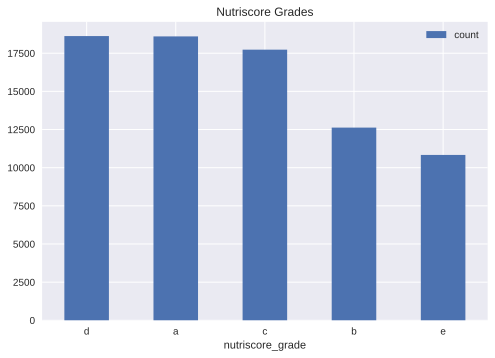

In [ ]:
import matplotlib.pyplot as plt

grades_df = grades.toPandas()
grades_df.plot.bar(x = "nutriscore_grade", y = "count", rot = 0, title = "Nutriscore Grades");

### Pie Chart of Nutriscore Grade Distribution

Grades D, A, and C are pretty evenly distributed.

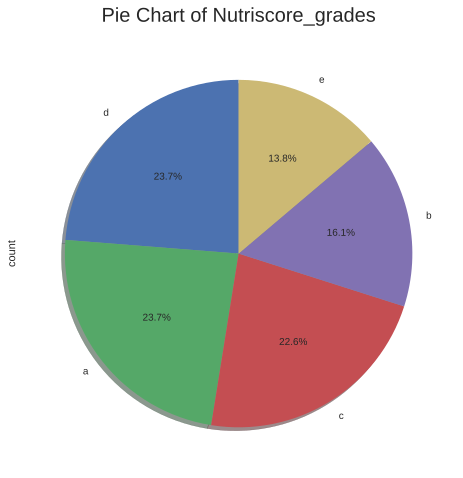

In [ ]:
import matplotlib.pyplot as plt

grades_df['count'].plot(kind = 'pie', subplots = True, shadow = True, startangle = 90, figsize=(8,8), autopct='%1.1f%%', labels = grades_df['nutriscore_grade'])
plt.title("Pie Chart of Nutriscore_grades", y = 1.02, fontsize = 20)
plt.show()

# Converting our final french food dataset into a pandas dataframe and exporting it to csv file to be used in tableau for further visualizations

In [ ]:
french_food_df = french_food.toPandas()
french_food_df.to_csv('/content/drive/MyDrive/IDS 561/Project/cleaned_fooddata_nutriscore_grades.csv', encoding = 'utf-8', index = False, header = True)

# Healthy and Unhealthy Food

Our goal will be to build a classifer that can predict whether a given food will be healthy or unhealthy based on its nutritional value. Healthy Food will be considered as foods with a nutriscore grade of A or B. Unhealthy food will be foods with nutriscore grades of C or worse. We will be left with a binary column named healthy replacing the old nutriscore_grade column.

In [ ]:
from pyspark.sql.functions import regexp_replace

food_health = french_food \
  .withColumn("nutriscore_grade", regexp_replace('nutriscore_grade', "a", "1")) \
  .withColumn("nutriscore_grade", regexp_replace('nutriscore_grade', "b", "1")) \
  .withColumn("nutriscore_grade", regexp_replace('nutriscore_grade', "c", "0")) \
  .withColumn("nutriscore_grade", regexp_replace('nutriscore_grade', "d", "0")) \
  .withColumn("nutriscore_grade", regexp_replace('nutriscore_grade', "e", "0")) \

food_health = food_health.withColumnRenamed("nutriscore_grade", "healthy")

food_health = food_health.withColumn("healthy", food_health["healthy"].cast(IntegerType()))

food_health.show()

+-------------+-----------+-----------+--------+----------+-------------+-----------+-----------+---------+------------------+-------+
|         code|additives_n|energy_100g|fat_100g|fiber_100g|proteins_100g|sugars_100g|sodium_100g|salt_100g|carbohydrates_100g|healthy|
+-------------+-----------+-----------+--------+----------+-------------+-----------+-----------+---------+------------------+-------+
|0000000000100|        0.0|      936.0|     8.2|       0.0|          5.1|       22.0|       1.84|      4.6|              29.0|      0|
|0000000005470|        3.0|      669.0|     2.2|       1.6|          9.5|        0.6|     0.1432|    0.358|              25.2|      1|
|0000000274722|        2.0|      450.0|     2.2|       0.5|          6.8|        0.5|       0.28|      0.7|              15.3|      1|
|0000000491228|        4.0|     1952.4|    15.3|       0.1|          6.8|       69.8|        0.2|      0.5|              75.5|      1|
|0000010206515|        5.0|     1720.0|    6.42|       

## Visualizing Healthy and Unhealthy Food

### Creating a new dataframe grouping by 1 or 0 and each one's count

In [ ]:
healthy = food_health.groupBy("healthy").count().orderBy("count", ascending = False).persist()
healthy.show()

+-------+-----+
|healthy|count|
+-------+-----+
|      0|47189|
|      1|31228|
+-------+-----+



### Bar Chart comparing Healhy and Unhealthy food

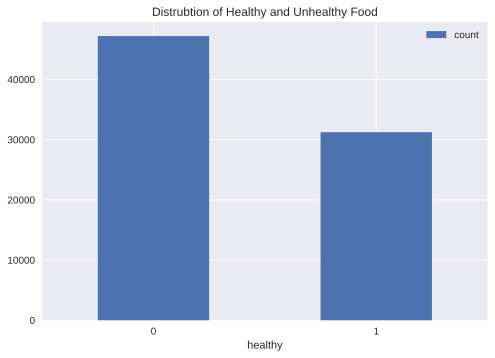

In [ ]:
import matplotlib.pyplot as plt

healthy_df = healthy.toPandas()
healthy_df.plot.bar(x = "healthy", y = "count", rot = 0, title = "Distrubtion of Healthy and Unhealthy Food");

### Pie Chart of Healthy and Unhealthy Food

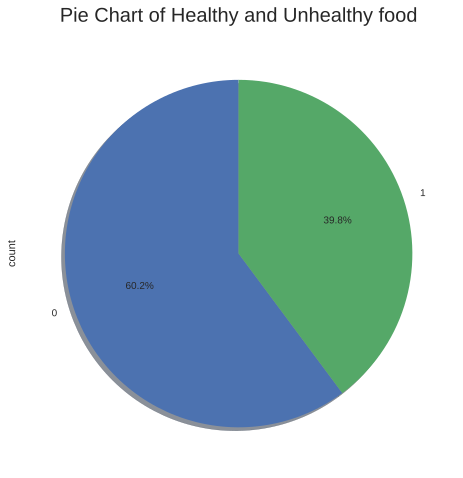

In [ ]:
import matplotlib.pyplot as plt

healthy_df['count'].plot(kind = 'pie', subplots = True, shadow = True, startangle = 90, figsize=(8,8), autopct='%1.1f%%', labels = healthy_df['healthy'])
plt.title("Pie Chart of Healthy and Unhealthy food", y = 1.02, fontsize = 20)
plt.show()

As we can see the majority of the dataset is made up of unhealthy foods.

# Modeling using the regular Pandas Libraries and Sklearn


Since our final dataset is small enough to use pandas we will create a model to compare our results with the pyspark library. Converting the spark dataframe to pandas dataframe and exporting to a CSV file

In [ ]:
healthy_food_df = food_health.toPandas()
healthy_food_df.to_csv('/content/drive/MyDrive/IDS 561/Project/healthy_food.csv', encoding = 'utf-8', index = False, header = True)

In [ ]:
healthy_food_df.drop('code', axis=1, inplace=True)
healthy_food_df

,additives_n,energy_100g,fat_100g,fiber_100g,proteins_100g,sugars_100g,sodium_100g,salt_100g,carbohydrates_100g,healthy
0,0.0,936.000000,8.20,0.0,5.10,22.000000,1.84000,4.6000,29.000000,0
1,3.0,669.000000,2.20,1.6,9.50,0.600000,0.14320,0.3580,25.200001,1
2,2.0,450.000000,2.20,0.5,6.80,0.500000,0.28000,0.7000,15.300000,1
3,4.0,1952.400024,15.30,0.1,6.80,69.800003,0.20000,0.5000,75.500000,1
4,5.0,1720.000000,6.42,0.0,0.03,81.669998,0.04000,0.1000,87.860001,0
...,...,...,...,...,...,...,...,...,...,...
78412,0.0,866.000000,13.00,5.4,18.00,0.800000,0.40000,1.0000,1.700000,1
78413,0.0,2629.000000,60.75,9.7,14.95,4.340000,0.00000,0.0000,16.700001,1
78414,5.0,2023.000000,22.00,7.5,9.60,23.000000,0.06000,0.1500,58.000000,0
78415,0.0,21.000000,0.20,0.2,0.50,0.500000,0.01016,0.0254,0.500000,0


create test and training datasets

In [ ]:
#Startified train test Split-out dataset
from sklearn.model_selection import train_test_split

features = []
for feature in healthy_food_df.columns:
    if feature != 'healthy':
        features.append(feature)
X = healthy_food_df[features]
Y = healthy_food_df['healthy']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

In [ ]:
# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## Random Forest

Accuracy on the training data 0.995409100183636


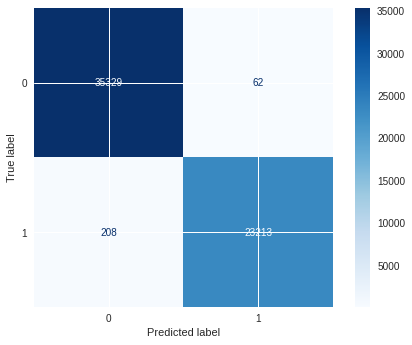

In [ ]:
#Random Forest
#Fitting the Random Forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

forest = RandomForestClassifier(n_estimators=10, random_state=42)
forest.fit(X_train, Y_train)

#the accuracy on the training data
print('Accuracy on the training data',forest.score(X_train,Y_train))

#confusion_matrix for the training
disp = plot_confusion_matrix(forest, X_train, Y_train ,display_labels=None, cmap=plt.cm.Blues)

Accuracy on the test data 0.9378729915837797
Precision: 0.938
Recall: 0.938
F1 Score: 0.938


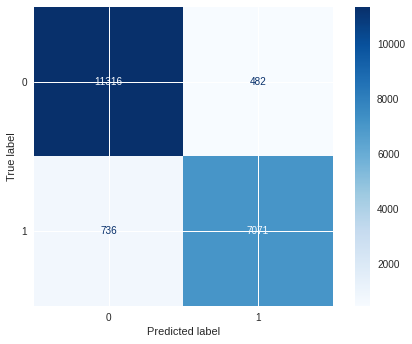

In [ ]:
# Testing the Random Forest Model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


#the accuracy on the test data
print('Accuracy on the test data', forest.score(X_test, Y_test))

#Precision, Recall & F1-Score
Y_pred = forest.predict(X_test)
print('Precision: %.3f' % precision_score(Y_test, Y_pred, average='micro'))
print('Recall: %.3f' % recall_score(Y_test, Y_pred, average='micro'))
print('F1 Score: %.3f' % f1_score(Y_test, Y_pred, average='micro'))

#confusion_matrix for the testing
disp = plot_confusion_matrix(forest, X_test, Y_test ,display_labels=None, cmap=plt.cm.Blues)

0.9803767001994833


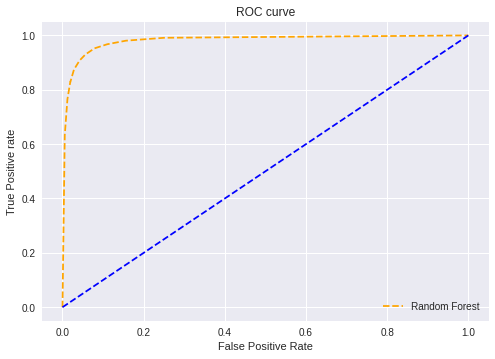

In [ ]:
#ROC curve and AUC value
pred_prob1 = forest.predict_proba(X_test)
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(Y_test, pred_prob1[:,1])

print(auc_score1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Decision Tree

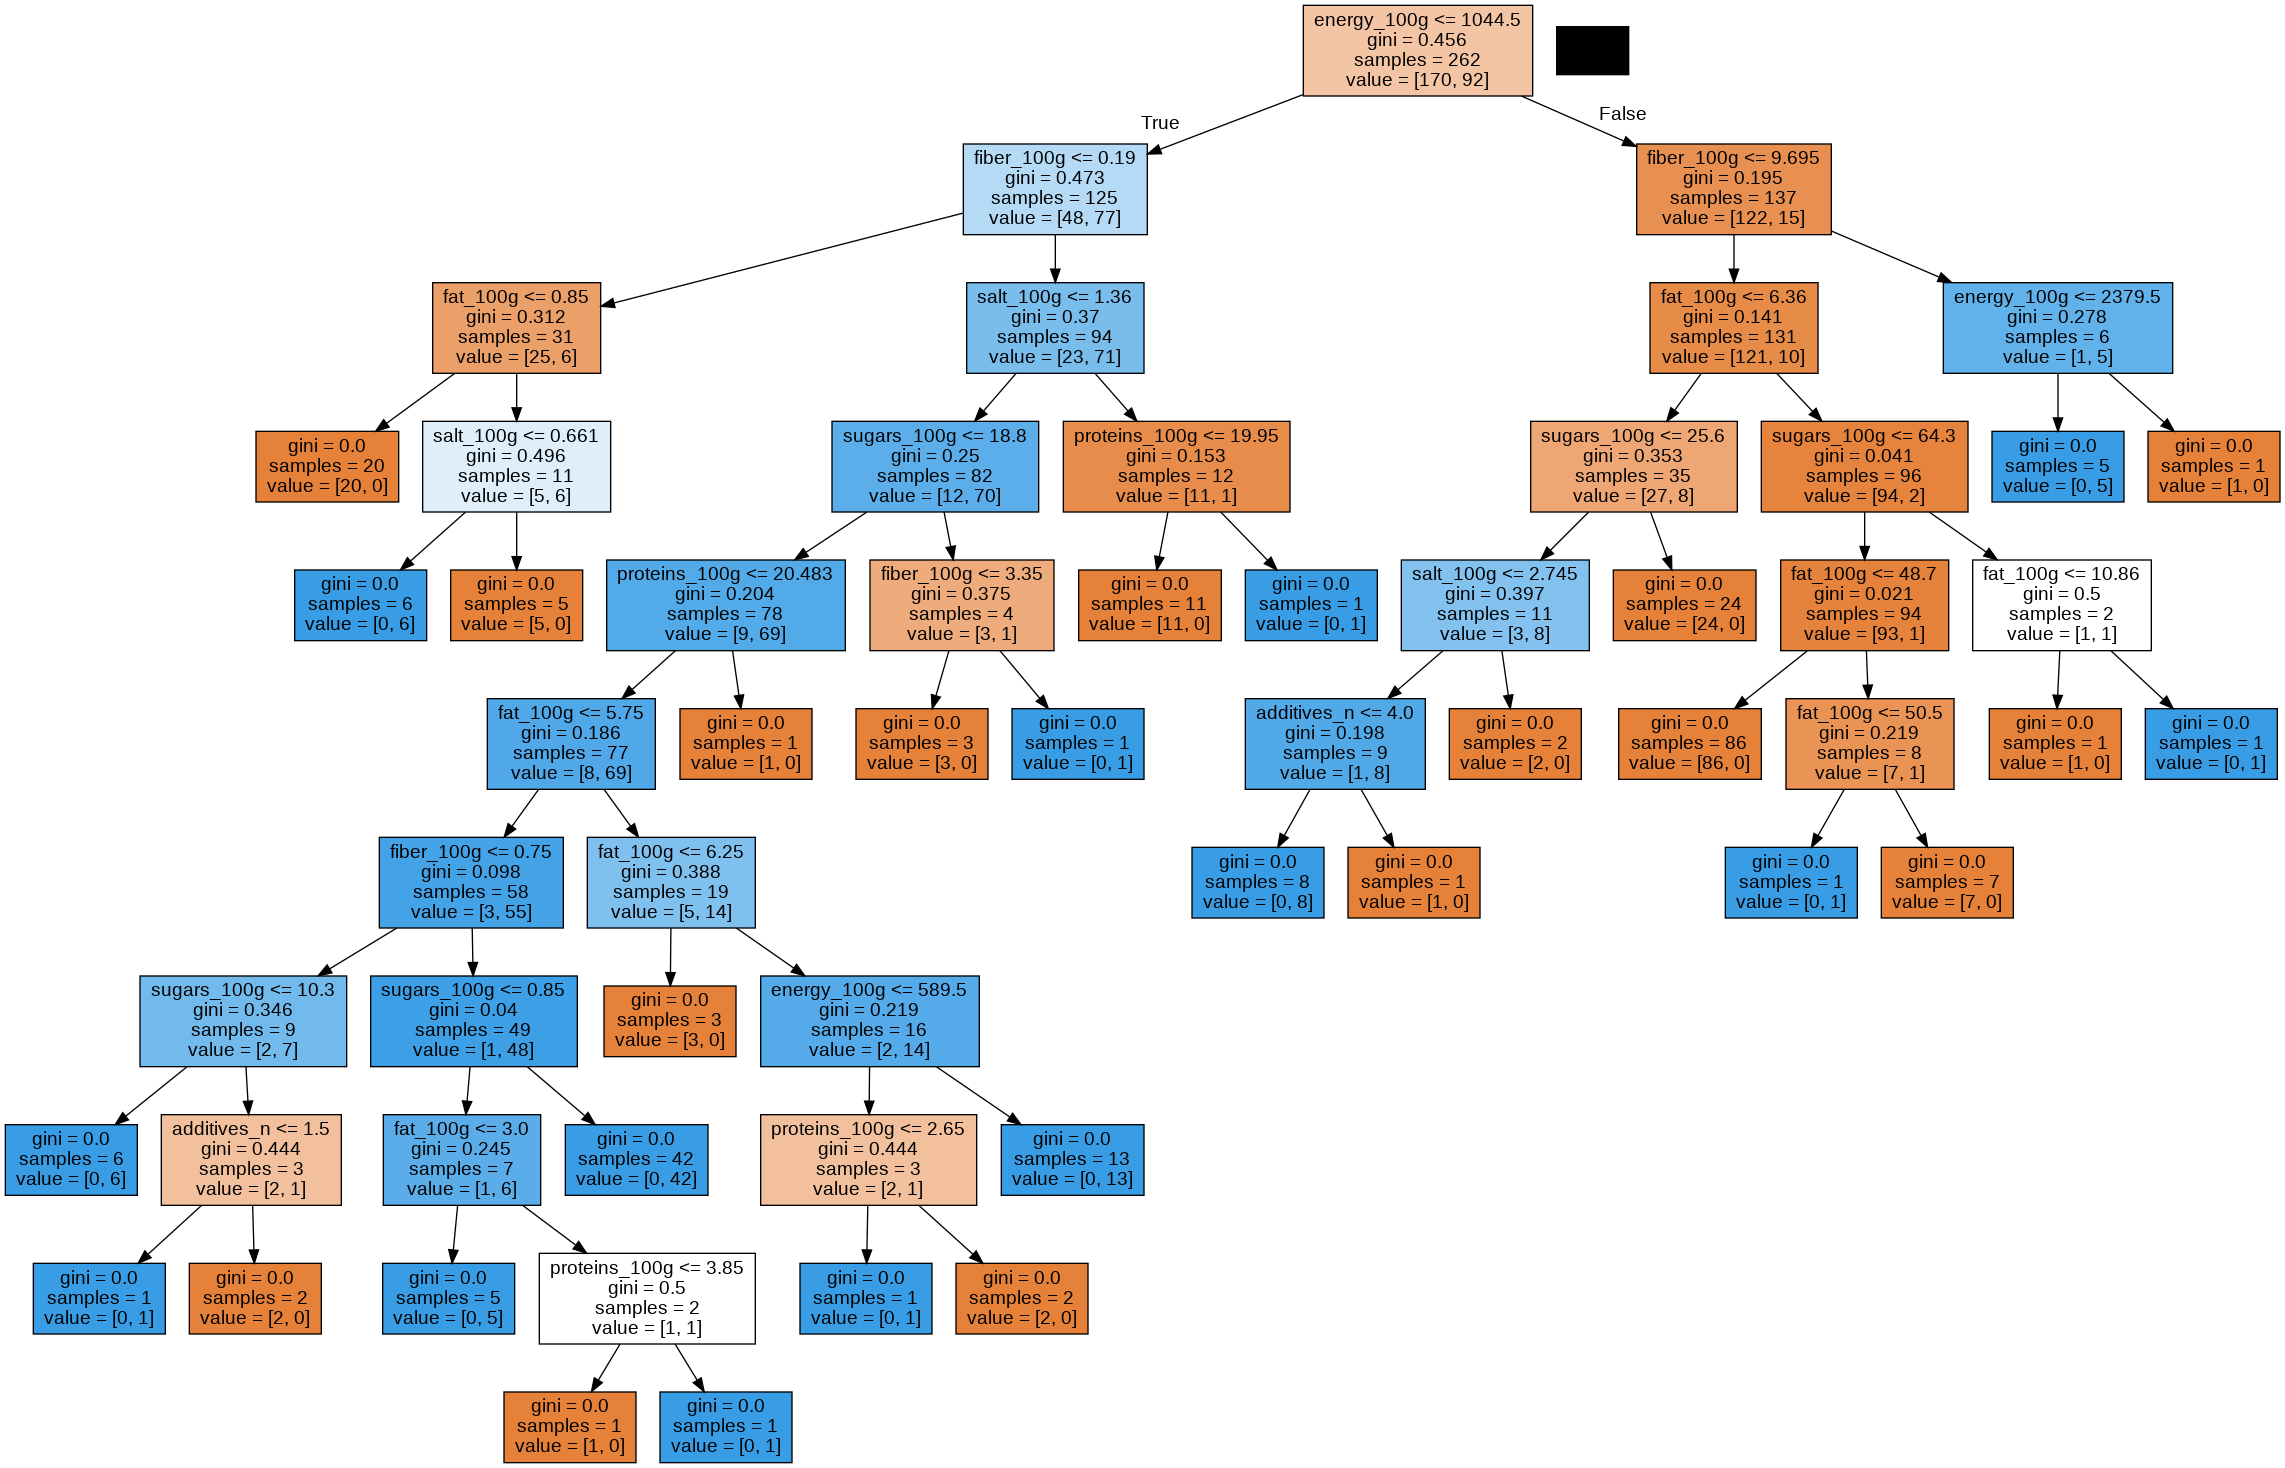

In [ ]:
# Decision Tree
#Import tools needed for visualization
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

df3=healthy_food_df[:350]

features = []
for feature in df3.columns:
    if feature != 'healthy':
        features.append(feature)
X3 = df3[features]
Y3 = df3['healthy']

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y3, stratify=Y3, test_size=0.25)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train3, Y_train3)

features = list(X_train3.columns)
#features.remove("loan_status")

dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

Accuracy on the training data 1.0


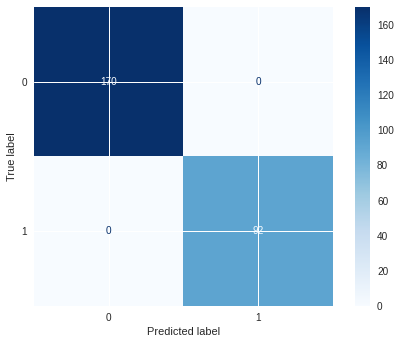

In [ ]:
#the accuracy on the training data
print('Accuracy on the training data',tree_clf.score(X_train3,Y_train3))

#confusion_matrix for the training
disp = plot_confusion_matrix(tree_clf, X_train3, Y_train3 ,display_labels=None, cmap=plt.cm.Blues)

Accuracy on the test data 0.9886363636363636
Precision: 0.989
Recall: 0.989
F1 Score: 0.989


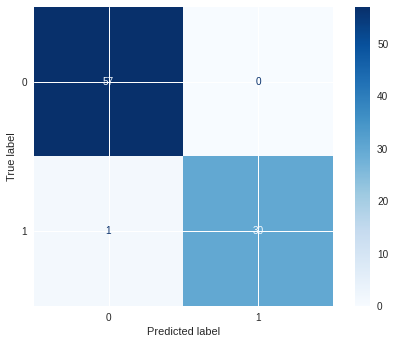

In [ ]:
# Testing the Desicion Tree Model

#the accuracy on the test data
print('Accuracy on the test data', forest.score(X_test3, Y_test3))

#Precision, Recall & F1-Score
Y_pred3 = forest.predict(X_test3)
print('Precision: %.3f' % precision_score(Y_test3, Y_pred3, average='micro'))
print('Recall: %.3f' % recall_score(Y_test3, Y_pred3, average='micro'))
print('F1 Score: %.3f' % f1_score(Y_test3, Y_pred3, average='micro'))

#confusion_matrix for the testing
disp = plot_confusion_matrix(forest, X_test3, Y_test3 ,display_labels=None, cmap=plt.cm.Blues)

0.8271080928126768


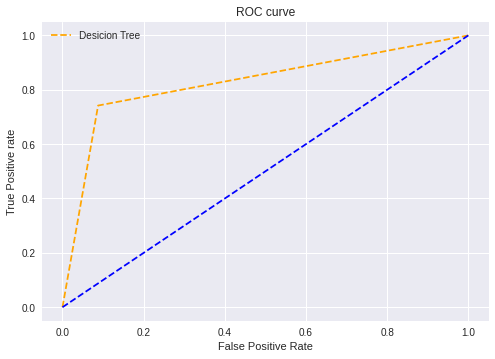

In [ ]:
#ROC curve and AUC value
pred_prob1 = tree_clf.predict_proba(X_test3)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test3, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(Y_test3))]
p_fpr, p_tpr, _ = roc_curve(Y_test3, random_probs, pos_label=1)


# auc scores
auc_score1 = roc_auc_score(Y_test3, pred_prob1[:,1])

print(auc_score1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Desicion Tree')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Naive Bayes Model

Accuracy for the Naive Bayes Model on the training data 73.2623


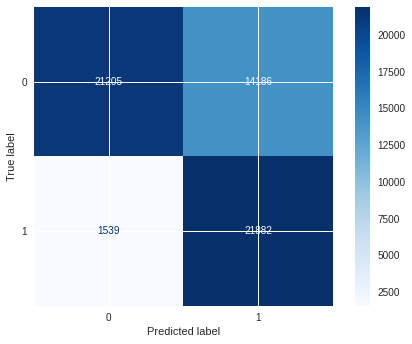

In [ ]:
#NAIVE BAYES MODEL
#Fitting the Naive Bayes Model - Baseline
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, Y_train)

#accuracy on the training data
gnb_train_acc = gnb.score(X_train,Y_train)
print('Accuracy for the Naive Bayes Model on the training data %.4f' % (gnb_train_acc*100))

#confusion_matrix for the training
disp = plot_confusion_matrix(gnb, X_train, Y_train ,display_labels = None, cmap=plt.cm.Blues)


Accuracy for the Naive Bayes Model on the test data 73.9505
Precision: 0.8071
Recall: 0.7395
F1 Score: 0.7392


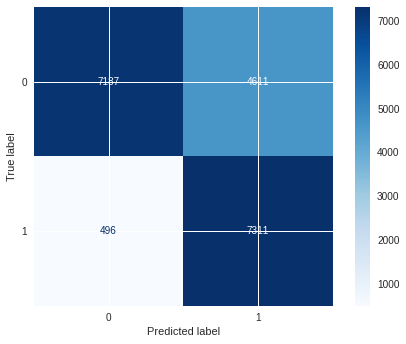

In [ ]:
#Testing the Naive Bayes Model- Baseline

#the accuracy on the test data
gnb_test_acc = gnb.score(X_test,Y_test)
print('Accuracy for the Naive Bayes Model on the test data %.4f' % (gnb_test_acc*100) )

#Precision, Recall & F1-Score
Y_naiveb = gnb.predict(X_test)
print('Precision: %.4f' % precision_score(Y_test, Y_naiveb, average='weighted'))
print('Recall: %.4f' % recall_score(Y_test, Y_naiveb, average='weighted'))
print('F1 Score: %.4f' % f1_score(Y_test, Y_naiveb, average='weighted'))

#confusion_matrix for the testing
disp = plot_confusion_matrix(gnb, X_test, Y_test ,display_labels=None, cmap=plt.cm.Blues)


0.8635594861393033


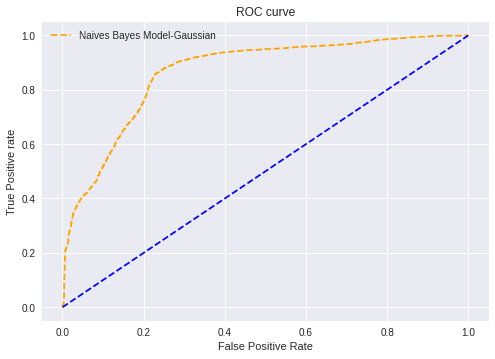

In [ ]:
#ROC curve and AUC value
pred_prob1 = gnb.predict_proba(X_test)
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(Y_test, pred_prob1[:,1])

print(auc_score1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Naives Bayes Model-Gaussian')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## K-Nearest Neighbor (KNN)

Accuracy for the KNeighborsClassifier on the training data 90.8624


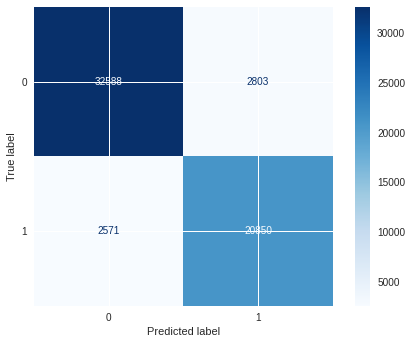

In [ ]:
#K-NEAREST NEIGHBOR (KNN) MODEL
#Fitting the KNN moel - Baseline
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train, Y_train)

#accuracy on the training data
knn_train_acc = knn.score(X_train,Y_train)
print('Accuracy for the KNeighborsClassifier on the training data %.4f'  % (knn_train_acc*100))

#confusion_matrix for the training
disp = plot_confusion_matrix(knn, X_train, Y_train ,display_labels=None, cmap=plt.cm.Blues)

Accuracy for the KNeighborsClassifier on the testing data 87.0339
Precision: 0.8709
Recall: 0.8703
F1 Score: 0.8705


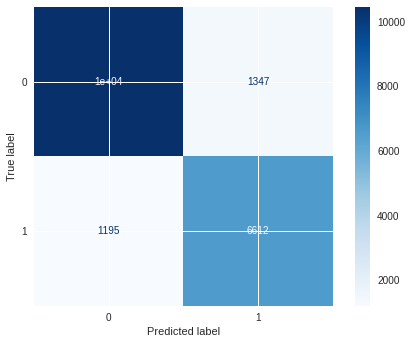

In [ ]:
# Testing the KNN Model- Baseline

#the accuracy on the test data
knn_test_acc = knn.score(X_test,Y_test)
print('Accuracy for the KNeighborsClassifier on the testing data %.4f'  % (knn_test_acc*100))

#Precision, Recall & F1-Score
Y_KNN = knn.predict(X_test)
print('Precision: %.4f' % precision_score(Y_test, Y_KNN, average='weighted'))
print('Recall: %.4f' % recall_score(Y_test, Y_KNN, average='weighted'))
print('F1 Score: %.4f' % f1_score(Y_test, Y_KNN, average='weighted'))

#confusion_matrix for the testing
disp = plot_confusion_matrix(knn, X_test, Y_test ,display_labels=None, cmap=plt.cm.Blues)


0.9326706879758284


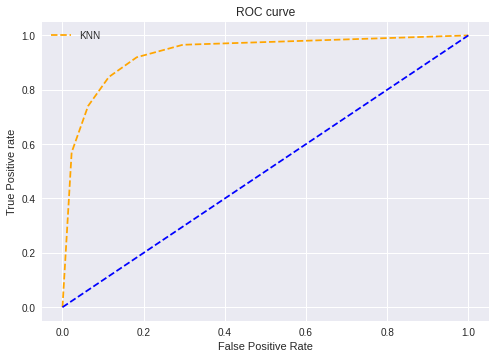

In [ ]:
#ROC curve and AUC value
pred_prob1 = knn.predict_proba(X_test)
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(Y_test, pred_prob1[:,1])

print(auc_score1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Logistic Regression

Accuracy for the Logistic Regression model on the training data 83.8383


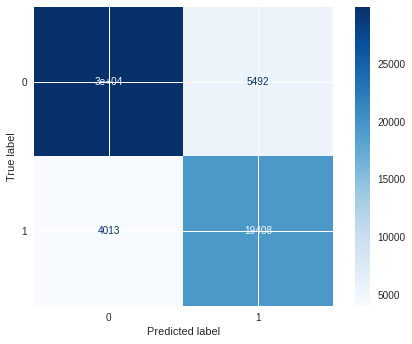

In [ ]:
#LOGISTIC REGRESSION
#Fitting the Regression moel - Baseline
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='liblinear', max_iter = 1000).fit(X_train, Y_train)

logistic_train_acc = logistic.score(X_train,Y_train)
print('Accuracy for the Logistic Regression model on the training data %.4f' % (logistic_train_acc*100))

#confusion_matrix for the training
disp = plot_confusion_matrix(logistic, X_train, Y_train ,display_labels=None, cmap=plt.cm.Blues)

#coefficients
#pd.DataFrame(zip(X_train.columns, np.transpose(logistic.coef_.tolist()[0])), columns=['features', 'coef'])

Accuracy for the Logistic Regression model on the test data 83.9633
Precision: 0.8420
Recall: 0.8396
F1 Score: 0.8403


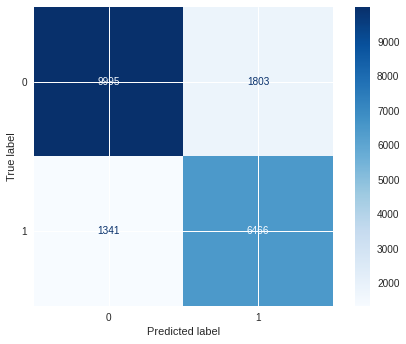

In [ ]:
# Testing the logistic Regression Model - Baseline

#the accuracy on the test data
logistic_test_acc = logistic.score(X_test,Y_test)
print('Accuracy for the Logistic Regression model on the test data %.4f' % (logistic_test_acc*100))

#Precision, Recall & F1-Score
Y_logi = logistic.predict(X_test)
print('Precision: %.4f' % precision_score(Y_test, Y_logi, average='weighted'))
print('Recall: %.4f' % recall_score(Y_test, Y_logi, average='weighted'))
print('F1 Score: %.4f' % f1_score(Y_test, Y_logi, average='weighted'))

#confusion_matrix for the testing
disp = plot_confusion_matrix(logistic, X_test, Y_test ,display_labels=None, cmap=plt.cm.Blues)

0.9164946891216265


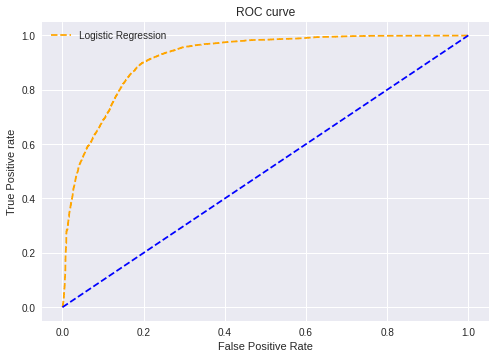

In [ ]:
#ROC curve and AUC value
pred_prob1 = logistic.predict_proba(X_test)
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(Y_test, pred_prob1[:,1])

print(auc_score1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Support Vector Machine

In [ ]:
##SVM MODEL
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC, SVC
lsvc = LinearSVC(verbose=0)

LinearSVC = SklearnClassifier(SVC(kernel='linear',probability=True))

lsvc.fit(X_train,Y_train)
score = lsvc.score(X_train,Y_train)
print("Score: ", score)


Score:  0.4212915731483371


Accuracy for Support Vector Machine model on the training data 42.1292


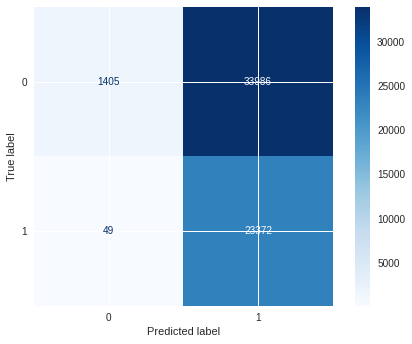

In [ ]:
#Fitting the SVM - Baseline
print('Accuracy for Support Vector Machine model on the training data %.4f' % (score*100))

#confusion_matrix for the training
disp = plot_confusion_matrix(lsvc, X_train, Y_train ,display_labels=None, cmap=plt.cm.Blues)

Accuracy on the test data 0.9378729915837797
Precision: 0.418
Recall: 0.418
F1 Score: 0.418


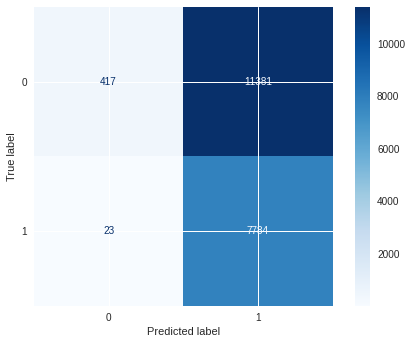

In [ ]:
# Testing the Random Forest Model

#the accuracy on the test data
print('Accuracy on the test data', forest.score(X_test, Y_test))

#Precision, Recall & F1-Score
Y_pred = lsvc.predict(X_test)
print('Precision: %.3f' % precision_score(Y_test, Y_pred, average='micro'))
print('Recall: %.3f' % recall_score(Y_test, Y_pred, average='micro'))
print('F1 Score: %.3f' % f1_score(Y_test, Y_pred, average='micro'))

#confusion_matrix for the testing
disp = plot_confusion_matrix(lsvc, X_test, Y_test ,display_labels=None, cmap=plt.cm.Blues)

0.8501074771896238


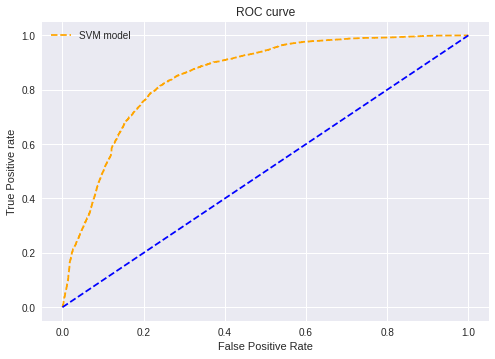

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
lsvc = CalibratedClassifierCV(lsvc)
lsvc.fit(X_train, Y_train)
y_proba = lsvc.predict_proba(X_test)

#ROC curve and AUC value
pred_prob1 = y_proba
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(Y_test, pred_prob1[:,1])

print(auc_score1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVM model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Crossvalidation

In [ ]:
#crossvalidation : is giving us better accuracy by using non supervised model using KNN and also is suggested to use
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import random
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score,make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

import warnings
warnings.filterwarnings('ignore')

SVC = SVC()

from sklearn.model_selection import cross_val_score

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": LinearSVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}


for key, classifier in classifiers.items():
    classifier.fit(X_train, Y_train)
    training_score = cross_val_score(classifier, X_train, Y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

#cross_val_score() function will be used to perform the evaluation, taking the dataset and cross-validation configuration and returning a list of scores calculated for each fold.
#to test the effectiveness of a machine learning models
#cv_results.mean() and cv_results.mean()

Classifiers:  LogisticRegression Has a training score of 83.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 87.0 % accuracy score
Classifiers:  LinearSVC Has a training score of 66.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 94.0 % accuracy score


# Modeling Using PySpark Machine Learning

## Preparing feautres for modeliing

In [ ]:
cols = food_health.columns
cols.remove('healthy')
cols.remove('code')

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = cols, outputCol = 'features')

data = assembler.transform(food_health)

In [ ]:
data.select("features").show(truncate=False, n=5)
data.select("healthy").show(truncate=False, n=5)

+-----------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------+
|[0.0,936.0,8.199999809265137,0.0,5.099999904632568,22.0,1.840000033378601,4.599999904632568,29.0]                                  |
|[3.0,669.0,2.200000047683716,1.600000023841858,9.5,0.6000000238418579,0.14319999516010284,0.3580000102519989,25.200000762939453]   |
|[2.0,450.0,2.200000047683716,0.5,6.800000190734863,0.5,0.2800000011920929,0.699999988079071,15.300000190734863]                    |
|[4.0,1952.4000244140625,15.300000190734863,0.10000000149011612,6.800000190734863,69.80000305175781,0.20000000298023224,0.5,75.5]   |
|[5.0,1720.0,6.420000076293945,0.0,0.029999999329447746,81.669

## Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train, test = data.randomSplit([0.8, 0.2], seed=12345)
lr = LogisticRegression(labelCol = 'healthy', featuresCol= 'features', maxIter=5, regParam=0.01, aggregationDepth=5, fitIntercept=True)
evaluator = BinaryClassificationEvaluator(labelCol = 'healthy')

bestModel = lr.fit(train)

lr_predictions = bestModel.transform(test)

LR_roc = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderROC"})
LR_pr = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderPR"})

print("Area under ROC Curve for Logistic Regression: {:.4f}".format(LR_roc))
print("Area under PR Curve for Logistic Regression: {:.4f}".format(LR_pr))

Area under ROC Curve for Logistic Regression: 0.9126
Area under PR Curve for Logistic Regression: 0.8433


## Support Vector Machine

In [ ]:
from pyspark.ml.classification import LinearSVC

train, test = data.randomSplit([0.8, 0.2], seed=12345)
svm = LinearSVC(maxIter=10, regParam=0.1, labelCol = 'healthy', featuresCol= 'features')
evaluator = BinaryClassificationEvaluator(labelCol = 'healthy')

bestModel = svm.fit(train)

svm_predictions = bestModel.transform(test)

SVM_roc = evaluator.evaluate(svm_predictions, {evaluator.metricName: "areaUnderROC"})
SVM_pr = evaluator.evaluate(svm_predictions, {evaluator.metricName: "areaUnderPR"})

print("Area under ROC Curve for SVM: {:.4f}".format(SVM_roc))
print("Area under PR Curve for SVM: {:.4f}".format(SVM_pr))

Area under ROC Curve for SVM: 0.9018
Area under PR Curve for SVM: 0.8393


## Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

train, test = data.randomSplit([0.8, 0.2], seed=12345)
dt = DecisionTreeClassifier(labelCol = 'healthy', featuresCol= 'features')
evaluator = BinaryClassificationEvaluator(labelCol = 'healthy')

bestModel = dt.fit(train)

dt_predictions = bestModel.transform(test)

DT_roc = evaluator.evaluate(dt_predictions, {evaluator.metricName: "areaUnderROC"})
DT_pr = evaluator.evaluate(dt_predictions, {evaluator.metricName: "areaUnderPR"})

print("Area under ROC Curve: {:.4f}".format(DT_roc))
print("Area under PR Curve: {:.4f}".format(DT_pr))

Area under ROC Curve: 0.8415
Area under PR Curve: 0.8056


## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

train, test = data.randomSplit([0.8, 0.2], seed=12345)
rf = RandomForestClassifier(numTrees = 10, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=50, labelCol = 'healthy', featuresCol= 'features')
evaluator = BinaryClassificationEvaluator(labelCol = 'healthy')

bestModel = rf.fit(train)

rf_predictions = bestModel.transform(test)

RF_roc = evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})
RF_pr = evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderPR"})

print("Area under ROC Curve: {:.4f}".format(RF_roc))
print("Area under PR Curve: {:.4f}".format(RF_pr))

Area under ROC Curve: 0.9293
Area under PR Curve: 0.8962


## Model Evaluation

In [ ]:
!pip install beautifultable
from beautifultable import BeautifulTable

table = BeautifulTable()

table.rows.append(['Random Forest', RF_roc, RF_pr])
table.rows.append(['Logistic Regression', LR_roc, LR_pr])
table.rows.append(['Support Vectot Machines', SVM_roc, SVM_pr])
table.rows.append(['Decision Tree', DT_roc, DT_pr])

table.columns.header = ['MODEL', 'ROC AUC', 'PR AUC' ]

print(table)

+-------------------------+---------+--------+
|          MODEL          | ROC AUC | PR AUC |
+-------------------------+---------+--------+
|      Random Forest      |  0.929  | 0.896  |
+-------------------------+---------+--------+
|   Logistic Regression   |  0.913  | 0.843  |
+-------------------------+---------+--------+
| Support Vectot Machines |  0.902  | 0.839  |
+-------------------------+---------+--------+
|      Decision Tree      |  0.842  | 0.806  |
+-------------------------+---------+--------+


Overall, our random forest model performed the best out of the models when looking at the area under the ROC curve and the area under the Precision Recall curve.

## Feature Importance

getting the feature importance from our best performing model, random forest.

In [ ]:
print(bestModel.featureImportances)

(9,[0,1,2,3,4,5,6,7,8],[0.01603819428053513,0.04694981568031481,0.4166484838286199,0.08552492017485679,0.02514044926196023,0.18593688421887414,0.14416240601916264,0.06091339941683471,0.01868544711884167])


saving the feature importance for each variable into a list

In [ ]:
importance = []

for i in range(9):
  importance.append(bestModel.featureImportances[i])

print(importance)

[0.01603819428053513, 0.04694981568031481, 0.4166484838286199, 0.08552492017485679, 0.02514044926196023, 0.18593688421887414, 0.14416240601916264, 0.06091339941683471, 0.01868544711884167]


creating a list of features and making a dictionary for feature, importance as key, value pairs.

In [ ]:
features = ['additives_n', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'sugars_100g', 'sodium_100g', 'salt_100g', 'carbohydrates_100g']

feature_importance = {'Feature':features, 'Importance':importance}
feature_importance

{'Feature': ['additives_n',
  'energy_100g',
  'fat_100g',
  'fiber_100g',
  'proteins_100g',
  'sugars_100g',
  'sodium_100g',
  'salt_100g',
  'carbohydrates_100g'],
 'Importance': [0.01603819428053513,
  0.04694981568031481,
  0.4166484838286199,
  0.08552492017485679,
  0.02514044926196023,
  0.18593688421887414,
  0.14416240601916264,
  0.06091339941683471,
  0.01868544711884167]}

converting the dictionary into a dataframe and sorting values by importance in descending value.

In [ ]:
import pandas as pd

feature_importance_df = pd.DataFrame(feature_importance)
feature_importance_df = feature_importance_df.sort_values(by = ["Importance"], ascending = False)

feature_importance_df

,Feature,Importance
2,fat_100g,0.416648
5,sugars_100g,0.185937
6,sodium_100g,0.144162
3,fiber_100g,0.085525
7,salt_100g,0.060913
1,energy_100g,0.046950
4,proteins_100g,0.025140
8,carbohydrates_100g,0.018685
0,additives_n,0.016038


visualizing feature importance

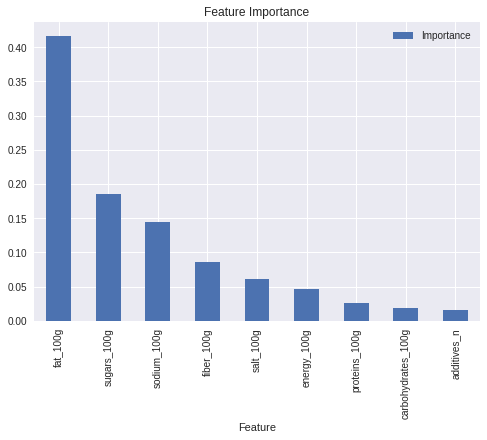

In [ ]:
feature_importance_df.plot.bar(x = "Feature", y = "Importance", rot = 90, title = "Feature Importance")

As we can see, fat is by far the most important feature when predicting whether a food is healthy or not. Sugar and sodium are the next two important factors. This aligns with food studies that claim foods high in fat, sugar, and sodium are unhealthy and lead to health problems if they are staple in one's diet.